In [1]:
import os
import nltk
import math
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Embedding, BatchNormalization, Activation, Input, Add, Concatenate,\
                         Bidirectional, SimpleRNN, LSTM, GRU
from keras_layer_normalization import LayerNormalization
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Embedding, Dropout, BatchNormalization, Activation, Input, \
    Conv1D, MaxPool1D, Flatten, Concatenate, Add, MaxPooling1D,LSTM
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

Using TensorFlow backend.


In [2]:
def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type|: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results
    
def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

In [3]:
def get_index(lst=None, item=''):
        tmp = []
        tag = 0
        for i in range(len(lst)):
            if lst[i] == item:
                tmp.append(i)
            
        return tmp


In [4]:
df = pd.read_csv("questiontext.csv")
anony = []
anony_view = []
anony_count = []
non_anony = []
non_anony_view = []
non_anony_count = []
for i in range(df.shape[0]):   
    if(df["anonymous_answer_count"][i] > 0):
        anony.append(df["question_title_list"][i])
        anony_view.append(df["no_of_view_list"][i])
        anony_count.append(df["answer_count_list"][i])
    else:
        non_anony.append(df["question_title_list"][i])
        non_anony_view.append(df["no_of_view_list"][i])
        non_anony_count.append(df["answer_count_list"][i])

In [5]:
df1 = df[["no_of_view_list","answer_count_list"]]
df1.describe()

,no_of_view_list,answer_count_list
count,1.112700e+04,11127.000000
mean,1.891206e+04,5.207423
std,2.594919e+05,17.738268
min,0.000000e+00,1.000000
25%,4.530000e+02,1.000000
50%,8.270000e+02,2.000000
75%,1.638000e+03,5.000000
max,1.356339e+07,783.000000


In [6]:
def probability_distribution(data, bins_interval=1, margin=1):
    bins = range(min(data), max(data) + bins_interval - 1, bins_interval)
    print(len(bins))
    for i in range(0, len(bins)):
        print(bins[i])
    plt.xlim(min(data) - margin, max(data) + margin)
    plt.title("Probability-distribution")
    plt.xlabel('Interval')
    plt.ylabel('Probability')
    # 频率分布normed=True，频次分布normed=False
    prob,left,rectangle = plt.hist(x=data, bins=bins, normed=True, histtype='bar', color=['r'])
    for x, y in zip(left, prob):
        # 字体上边文字
        # 频率分布数据 normed=True
        plt.text(x + bins_interval / 2, y + 0.003, '%.2f' % y, ha='center', va='top')
        # 频次分布数据 normed=False
        # plt.text(x + bins_interval / 2, y + 0.25, '%.2f' % y, ha='center', va='top')
    plt.show()

In [7]:
bins = range(min(anony_view),max(anony_view),1)
#probability_distribution(anony_view, bins_interval=1, margin=1)

In [8]:
df = pd.read_csv("questiontext.csv")
train_texts = df["question_title_list"]
print(len(train_texts))
train_labels = df["anonymity_label"]
anonymity_list = get_index(train_labels,1)
print("number of anonymity questions: ",len(anonymity_list))
anonymity_questions = [train_texts[i] for i in anonymity_list]
print(len(anonymity_questions))
non_anonymity_list = get_index(train_labels,0)
non_anonymity_questions = [train_texts[i] for i in non_anonymity_list]
print(len(non_anonymity_questions))

11127
number of anonymity questions:  1578
1578
9549


In [9]:
def plotZ(label = None,num_list1 = [],num_list2 = [],xname = ''): 
    x =list(range(len(num_list1)))  
    total_width, n = 0.8, 2  
    width = total_width / n
    plt.rcParams['font.sans-serif']=['SimHei']
    fmt='%.2f%%'
    yticks = mtick.FormatStrFormatter(fmt)  #设置百分比形式的坐标轴
    fig = plt.figure()  
    ax1 = fig.add_subplot(111)  
    ax1.plot(x, num_list2,'or-',label = 'SeriousDlqin2yrs');
    ax1.yaxis.set_major_formatter(yticks)
    ax1.legend(loc='upper right')
    ax1.set_ylabel('percentage(%)');
    plt.legend()  
    ax2 = ax1.twinx() # this is the important function  
    plt.bar(x,num_list1,width = width,alpha=0.3,color='blue',label= xname)  
    ax2.legend(loc='lower right')
    plt.legend(loc="upper right") 
    plt.xticks(x,label)

    

In [10]:
import matplotlib.ticker as mtick 
def plotting(label,list1,list2):
    x = list(range(len(list1)))
    total_width, n = 0.8, 2  
    width = total_width / n
    fmt='%.2f%%'
    yticks = mtick.FormatStrFormatter(fmt)  #设置百分比形式的坐标轴
    plt.rcParams['savefig.dpi'] = 300 #图片像素
    plt.rcParams['figure.dpi'] = 300 #分辨率
    

    fig = plt.figure(figsize=(24,12))  
    ax1 = fig.add_subplot(111)  
    ax1.plot(x, list1,'or-',label = 'Question anonymity ratio')
    ax1.yaxis.set_major_formatter(yticks)
    ax1.tick_params(labelsize=15)
    ax1.legend(fontsize=20)
    ax1.set_ylabel('percentage(%)',fontsize=17)
    ax2 = ax1.twinx() # this is the important function
    yticks = mtick.FormatStrFormatter(fmt)  #设置百分比形式的坐标轴
    ax2.yaxis.set_major_formatter(yticks)
    plt.bar(x,list2,width = 0.4,alpha=0.3,color='blue',label= 'Fraction of questions without response')  
    ax2.legend(loc='upper center',fontsize=20)
    #plt.legend(loc="upper right") 
    plt.xticks(x,label)
    plt.tick_params(labelsize=20)


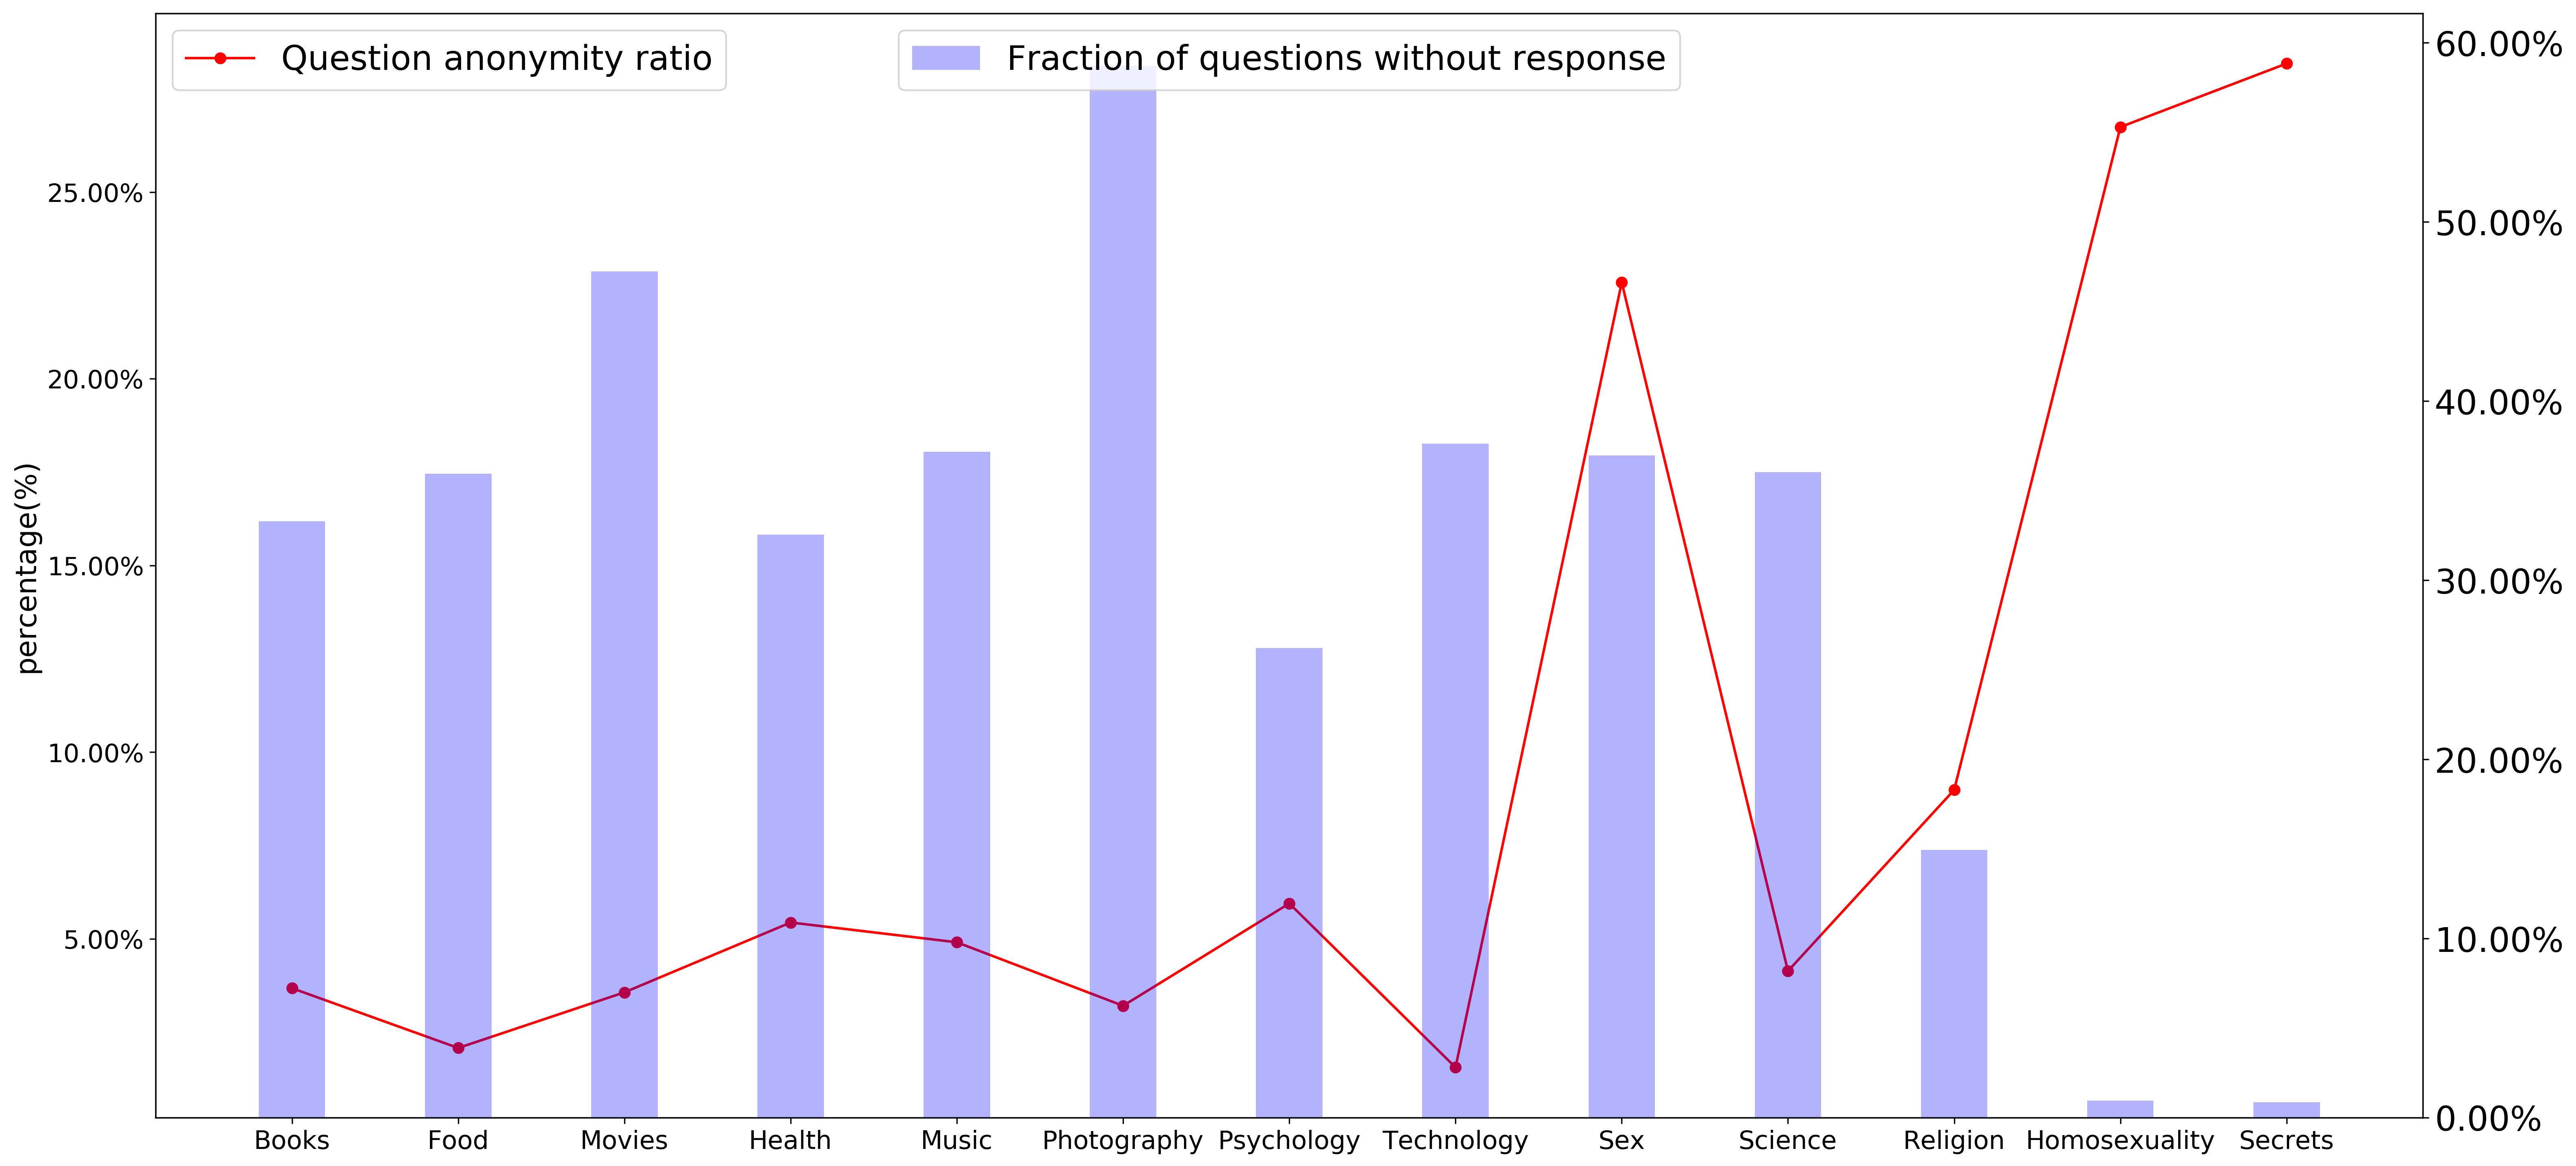

In [11]:
label = ['Books','Food','Movies','Health','Music','Photography','Psychology','Technology','Sex',
         'Science','Religion','Homosexuality','Secrets']
list1 = [3.68,2.08,3.57,5.44,4.91,3.21,5.95,1.56,22.58,4.14,8.99,26.74,28.44]
list2 = [33.29,35.94,47.24,32.54,37.17,58.71,26.22,37.62,36.97,36.03,14.94,0.96,0.85]
plotting(label,list1,list2)

         
         
         

In [14]:
from nltk import FreqDist
def getfreq(list,word):
    num = 0
    for i in list:
        fdist = FreqDist(i)
        num += fdist[word]
        
    return num

In [15]:
anon_train_tokens = [tokenize(text) for text in anony]
anon_tokens = []
for text in anon_train_tokens:
    
    text1 = [i.lower() for i in text]
    anon_tokens.append(text1)
print("number of anonymity questions:  9549")
words = ["what","how","why","which","where","who","when"]
anon_list = []
for word in words:
    print(word," : ",getfreq(anon_tokens,word))
    anon_list.append(100*getfreq(anon_tokens,word)/float(1578))
print(anon_list)


number of anonymity questions:  9549
what  :  573
how  :  111
why  :  113
which  :  69
where  :  15
who  :  72
when  :  51
[36.31178707224335, 7.034220532319392, 7.160963244613435, 4.3726235741444865, 0.9505703422053232, 4.562737642585551, 3.2319391634980987]


In [16]:
print("number of anonymity questions:  1578")
words = ["what","how","why","which","where","who","when"]
anon_list = []
for word in words:
    print(word," : ",getfreq(anon_tokens,word))
    anon_list.append(100*getfreq(anon_tokens,word)/float(1578))
print(anon_list)

number of anonymity questions:  1578
what  :  573
how  :  111
why  :  113
which  :  69
where  :  15
who  :  72
when  :  51
[36.31178707224335, 7.034220532319392, 7.160963244613435, 4.3726235741444865, 0.9505703422053232, 4.562737642585551, 3.2319391634980987]


In [17]:
non_anon_train_tokens = [tokenize(text) for text in non_anony]
non_anon_tokens = []
for text in non_anon_train_tokens:
    text1 = [i.lower() for i in text]
    non_anon_tokens.append(text1)
    
print("number of non-anonymity questions:  9549")
words = ["what","how","why","which","where","who","when"]
non_anon_list = []
for word in words:
    print(word," : ",getfreq(non_anon_tokens,word))
    non_anon_list.append(100*getfreq(non_anon_tokens,word)/float(9549))
print(non_anon_list)

number of non-anonymity questions:  9549
what  :  3951
how  :  1624
why  :  1267
which  :  463
where  :  193
who  :  462
when  :  588
[41.3760603204524, 17.0070164415122, 13.26840506859357, 4.848675253953293, 2.0211540475442455, 4.838202953188816, 6.157712849513038]


In [18]:
from collections import Counter
A_len = []
for text in anon_train_tokens:
    text1 = len(text)
    A_len.append(text1)
counter = Counter(A_len)
print(counter)

Counter({9: 96, 11: 86, 10: 79, 8: 73, 14: 70, 12: 63, 13: 62, 15: 56, 18: 48, 16: 41, 17: 39, 19: 37, 7: 32, 20: 28, 6: 23, 21: 22, 22: 19, 23: 18, 27: 16, 26: 14, 28: 13, 30: 13, 25: 12, 24: 12, 31: 10, 29: 10, 32: 9, 34: 9, 35: 7, 38: 7, 33: 6, 40: 6, 5: 5, 44: 5, 37: 5, 41: 4, 53: 4, 39: 4, 4: 3, 47: 3, 52: 3, 43: 3, 55: 3, 49: 3, 48: 3, 57: 2, 50: 2, 51: 2, 42: 2, 36: 2, 45: 1, 54: 1, 64: 1, 61: 1, 46: 1})


In [19]:
B_len = []
for text in non_anon_train_tokens:
    text1 = len(text)
    B_len.append(text1)
counter = Counter(B_len)
print(counter)

Counter({9: 788, 10: 785, 11: 758, 12: 682, 8: 587, 13: 563, 14: 536, 15: 456, 16: 389, 7: 379, 17: 367, 18: 289, 20: 266, 19: 252, 6: 228, 22: 221, 21: 210, 24: 167, 23: 159, 25: 147, 26: 126, 27: 113, 28: 111, 5: 101, 30: 92, 29: 90, 33: 84, 32: 82, 35: 74, 31: 71, 36: 57, 34: 57, 43: 55, 37: 52, 41: 52, 38: 52, 40: 46, 39: 44, 46: 38, 50: 36, 42: 36, 47: 35, 45: 35, 48: 31, 52: 30, 44: 29, 54: 26, 49: 24, 4: 18, 53: 17, 55: 16, 51: 16, 56: 10, 57: 8, 58: 7, 59: 6, 60: 5, 63: 3, 69: 3, 65: 3, 64: 2, 61: 2, 67: 2, 70: 1, 68: 1})


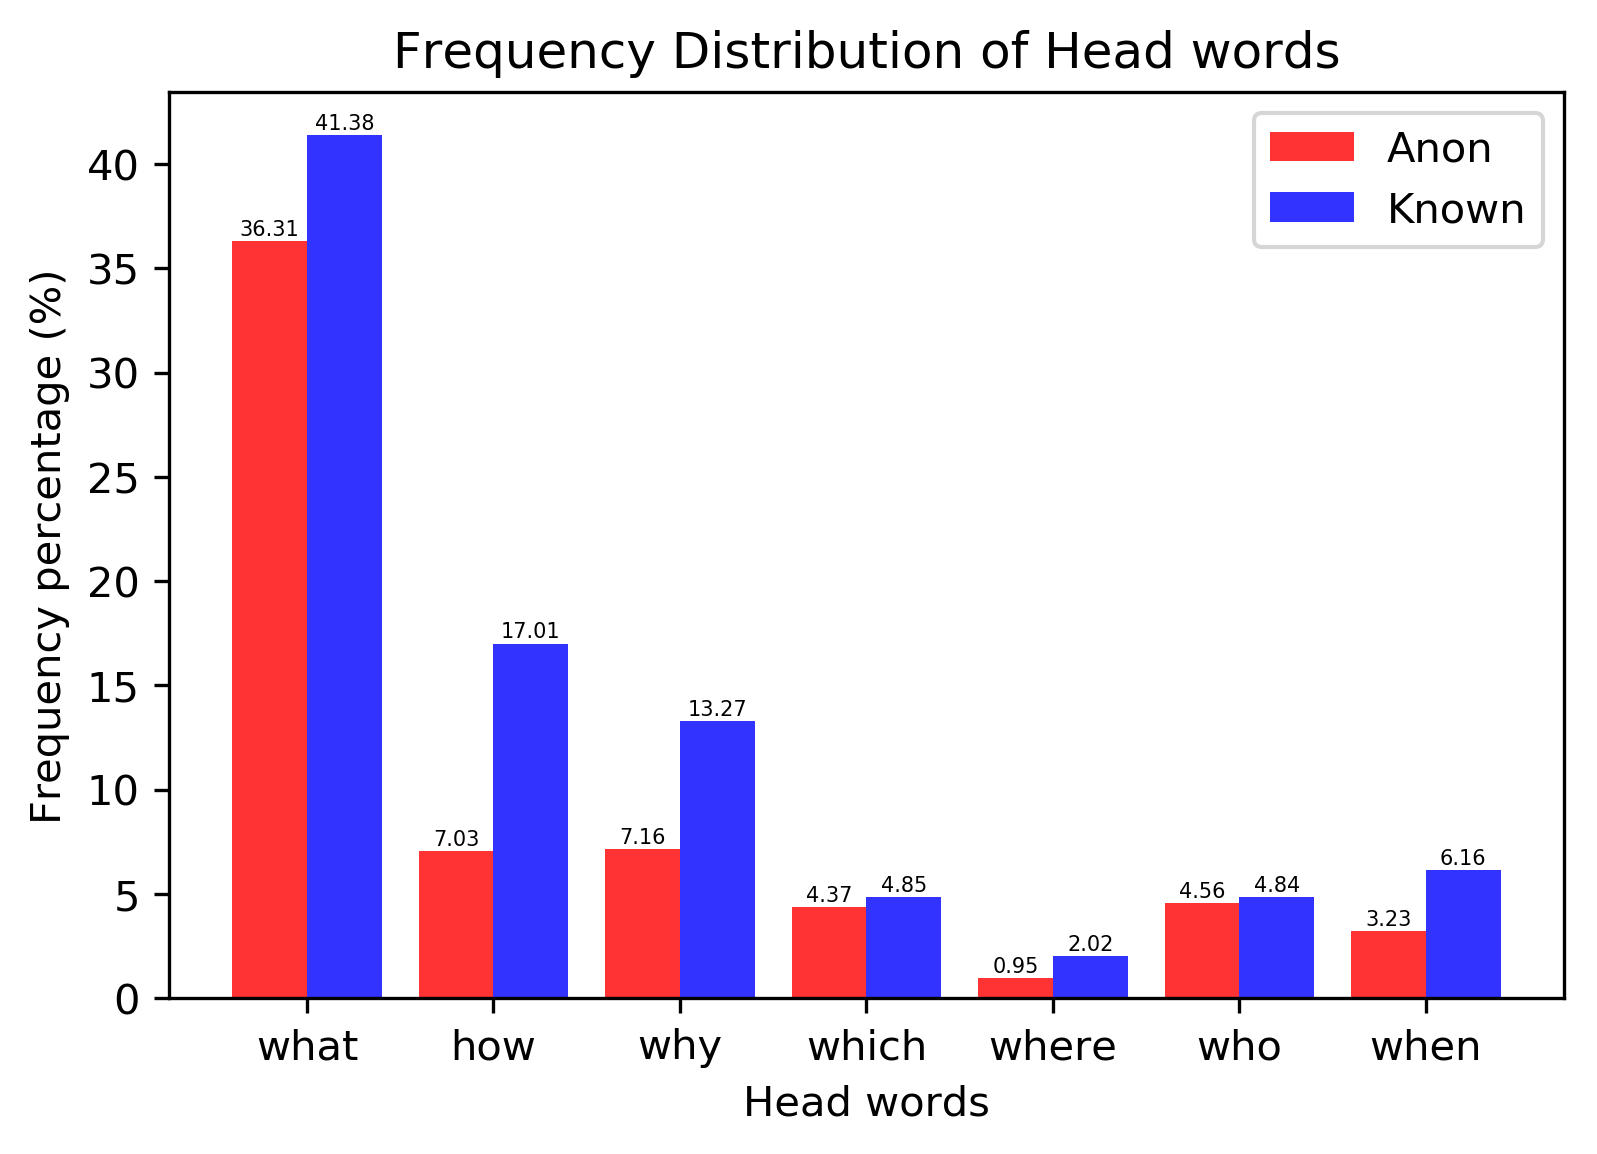

In [22]:
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率
xlen = range(len(anon_list))
rects1 = plt.bar(x=xlen, height=anon_list, width=0.4, alpha=0.8, color='red', label="Anon")
rects2 = plt.bar(x=[i + 0.4 for i in xlen], height=non_anon_list, width=0.4,alpha=0.8, color='blue', label="Known")
for a,b in zip(xlen,anon_list): ##控制标签位置
    plt.text(a,b+0.1,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=5)
for a,b in zip(xlen,non_anon_list):
    plt.text(a+0.4,b+0.1,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=5)

plt.ylabel("Frequency percentage (%)")
plt.xticks([index + 0.2 for index in xlen], words)
plt.xlabel("Head words")
plt.title("Frequency Distribution of Head words")
plt.legend() 
#plt.figure(figsize=(16, 8)).add_subplot(111)
plt.savefig('plot123_2.png', dpi=300)
plt.show()

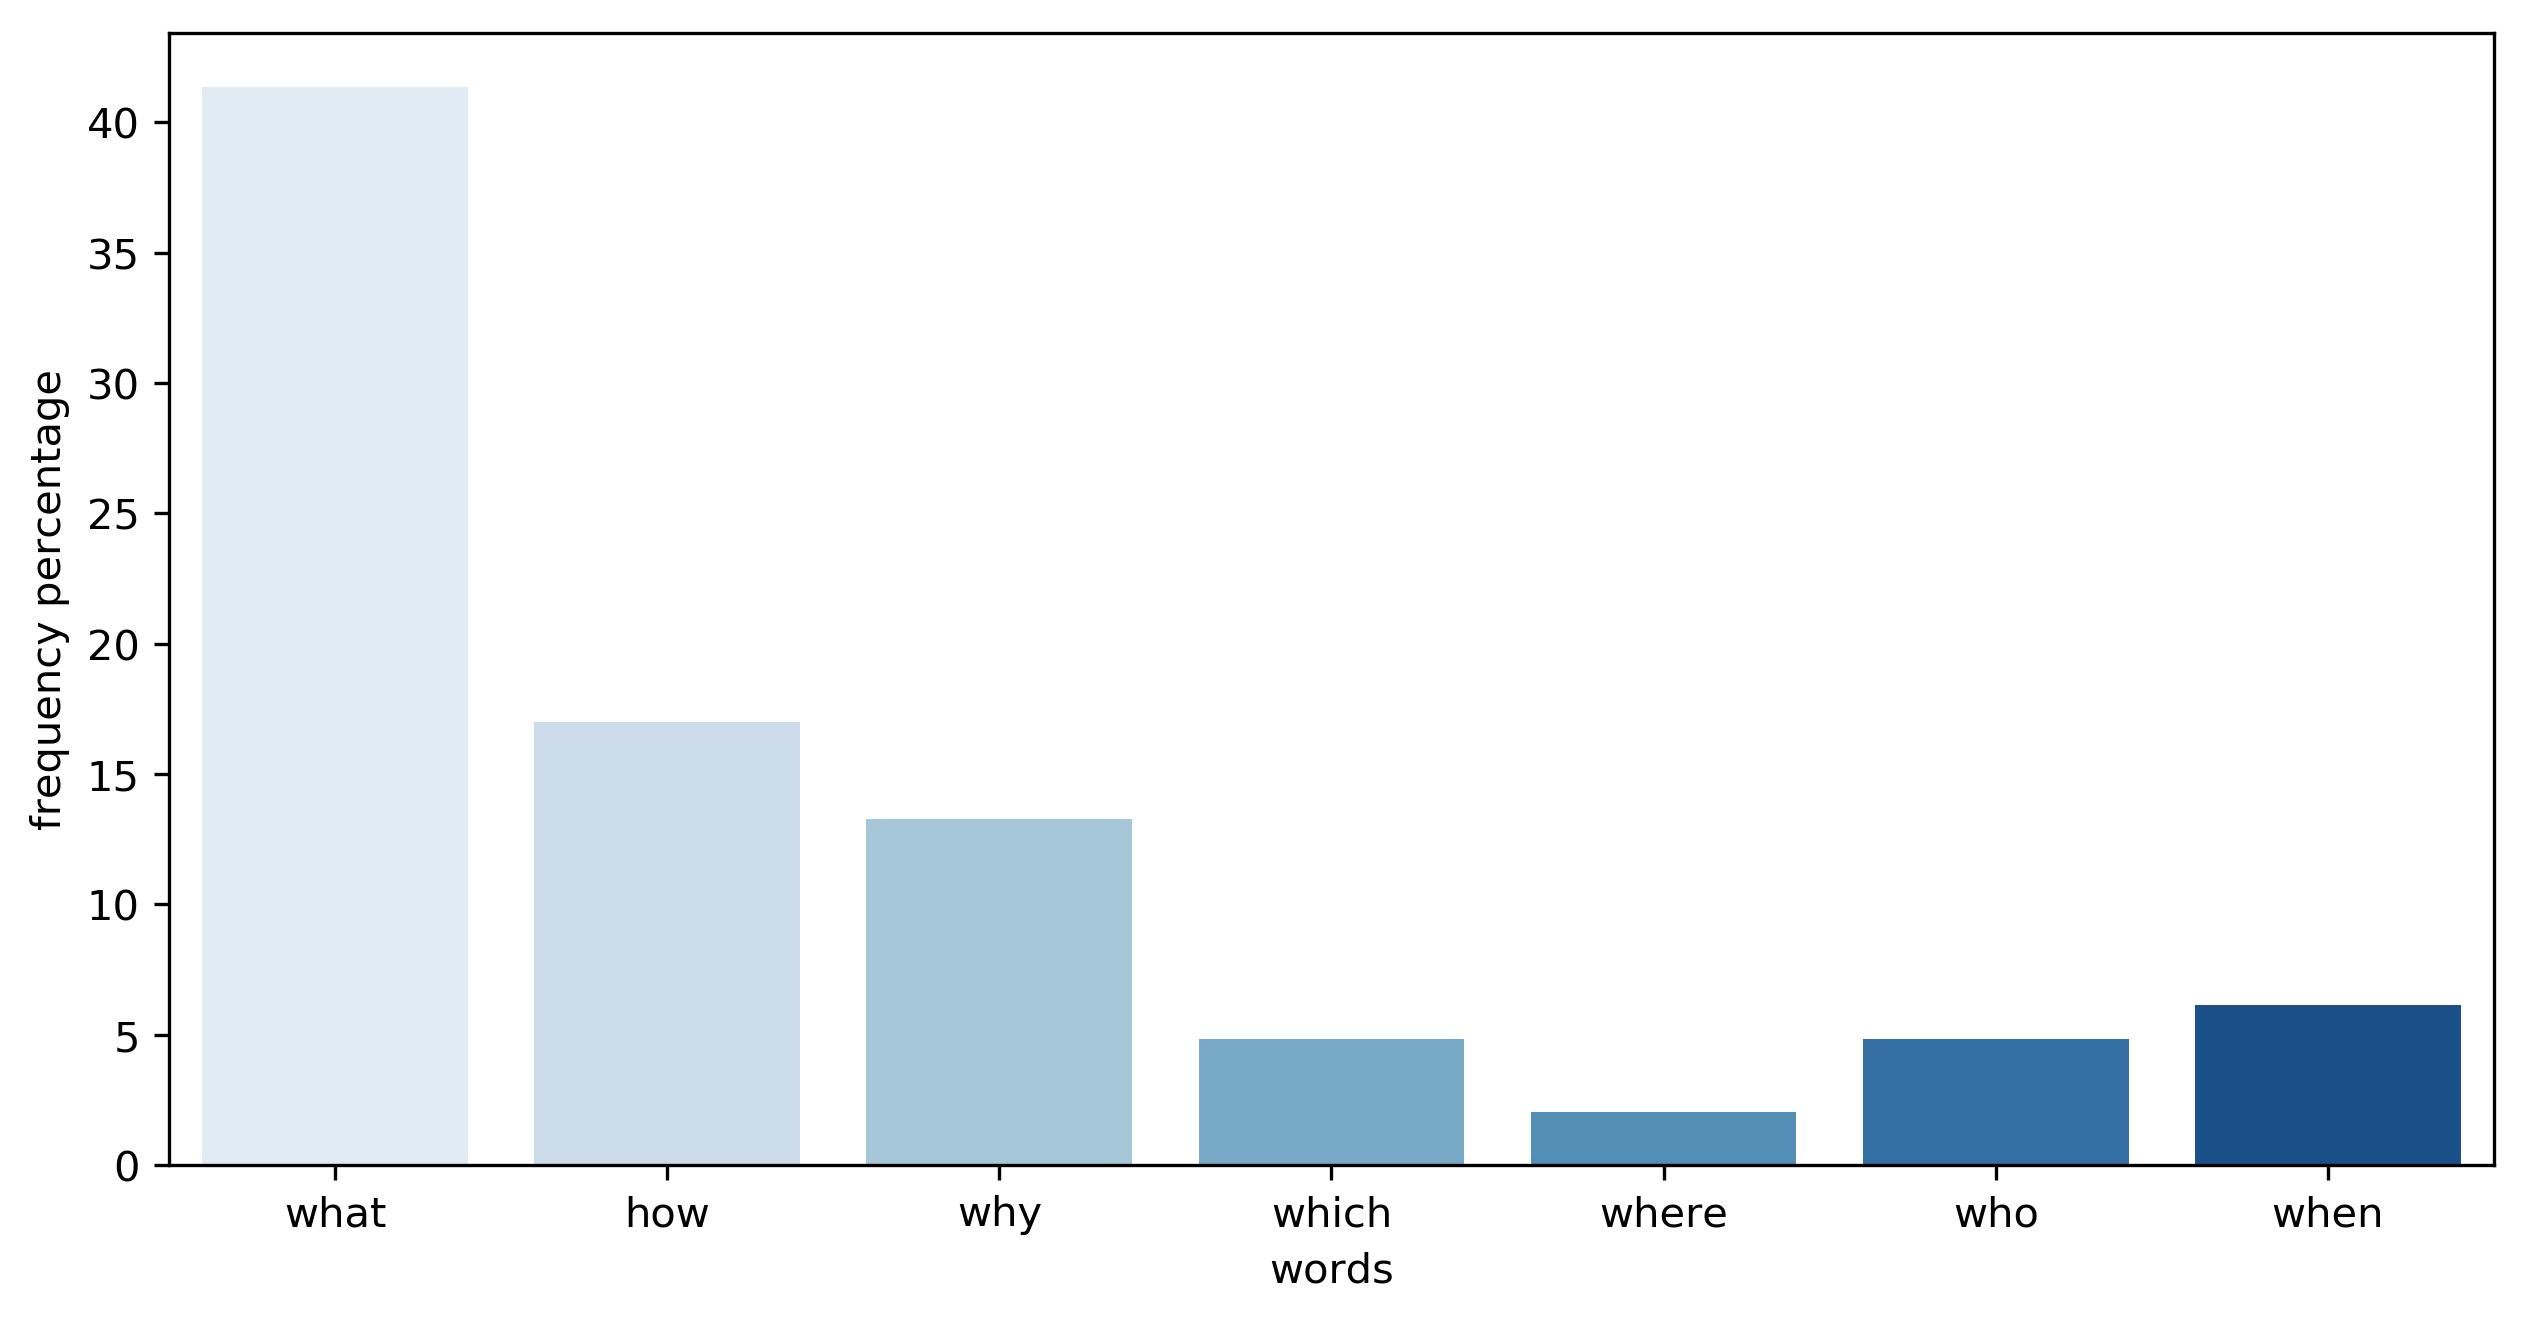

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
c={'words':words,'frequency percentage':anon_list}
e=pd.DataFrame(c)
ax = plt.figure(figsize=(10, 5)).add_subplot(111)
sns.barplot(x="words",y="frequency percentage",data=e,palette="Purples") #palette设置颜色
d={'words':words,'frequency percentage':non_anon_list}
f = pd.DataFrame(d)
sns.barplot(x="words",y="frequency percentage",data=f,palette="Blues") #palette设置颜色

In [24]:
print(train_texts[5])
train_tokens = [tokenize(text) for text in train_texts]
print(train_tokens[5])
tokens = []
for text in train_tokens:
    text2 = [i.lower() for i in text]
    text1 = []
    for i in text2:
        if(i != "?"):
            text1.append(i)
    tokens.append(text1)
train_tokens = tokens
print(train_tokens[5])
filtered_sentence = [filter_stopwords(text) for text in train_tokens]
print(filtered_sentence[5])
#print(len(train_tokens))
train_stemmed = [stem(tokens) for tokens in filtered_sentence]
#print(train_stemmed[0][0])
#print(len(train_stemmed))
train_2_gram = [n_gram(tokens, 2) for tokens in train_stemmed]
train_3_gram = [n_gram(tokens, 3) for tokens in train_stemmed]
train_feats = list()
for i in range(len(train_texts)):
    train_feats.append(
        train_stemmed[i] + train_2_gram[i])


What is the best explanation to explain the concept of evolution in the book Evolution?
['What', 'is', 'the', 'best', 'explanation', 'to', 'explain', 'the', 'concept', 'of', 'evolution', 'in', 'the', 'book', 'Evolution', '?']
['what', 'is', 'the', 'best', 'explanation', 'to', 'explain', 'the', 'concept', 'of', 'evolution', 'in', 'the', 'book', 'evolution']
['best', 'explanation', 'explain', 'concept', 'evolution', 'book', 'evolution']


stemmed feature size: 10703


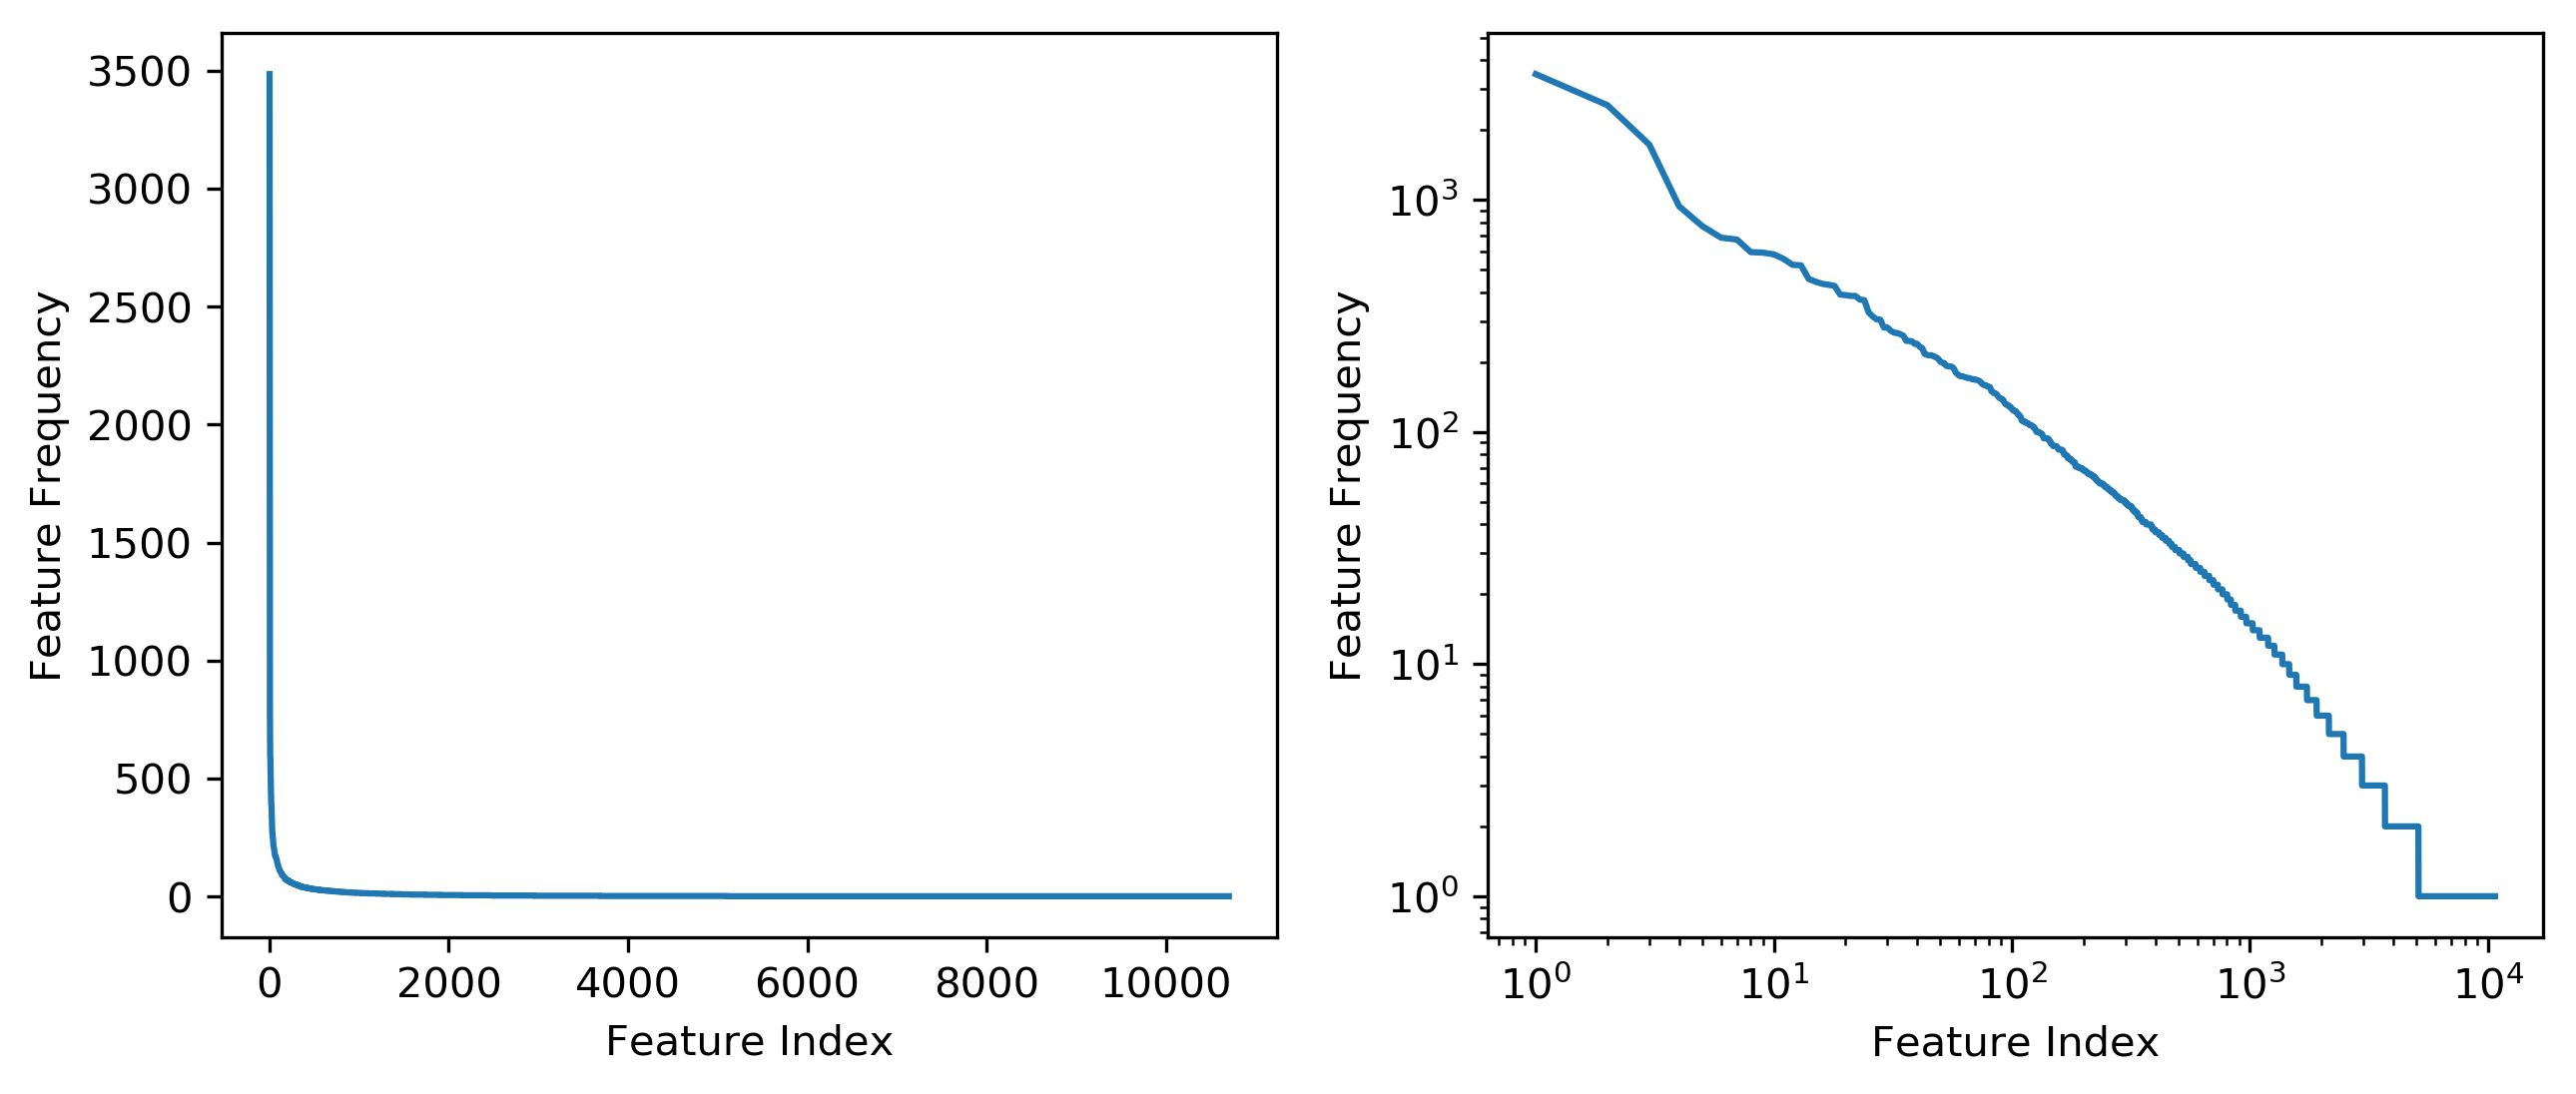

In [25]:
# first, build a Counter for stemmed features, e.g., {"text": 2, "mine": 1}
stemmed_feat_cnt = Counter(chain.from_iterable(train_stemmed)) 
print("stemmed feature size:", len(stemmed_feat_cnt))
# then, get the sorted features by the frequency
stemmed_feat_keys = [f for f, cnt in stemmed_feat_cnt.most_common()]
# draw linear lines and log lines for sorted features
# set the figure size
plt.figure(figsize=(10,4))
# generate two subfigures and set current as the first one 
plt.subplot(1,2,1)
# draw linear lines
plt.plot(list(range(1, len(stemmed_feat_cnt)+1)), [stemmed_feat_cnt[f] for f in stemmed_feat_keys])
# set labels
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
# set current as the second one
plt.subplot(1,2,2)
# draw log lines
plt.loglog(list(range(1, len(stemmed_feat_cnt)+1)),
           [stemmed_feat_cnt[f] for f in stemmed_feat_keys],
           basex=10, basey=10) # set labels
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
plt.show()

2-gram feature size: 59184


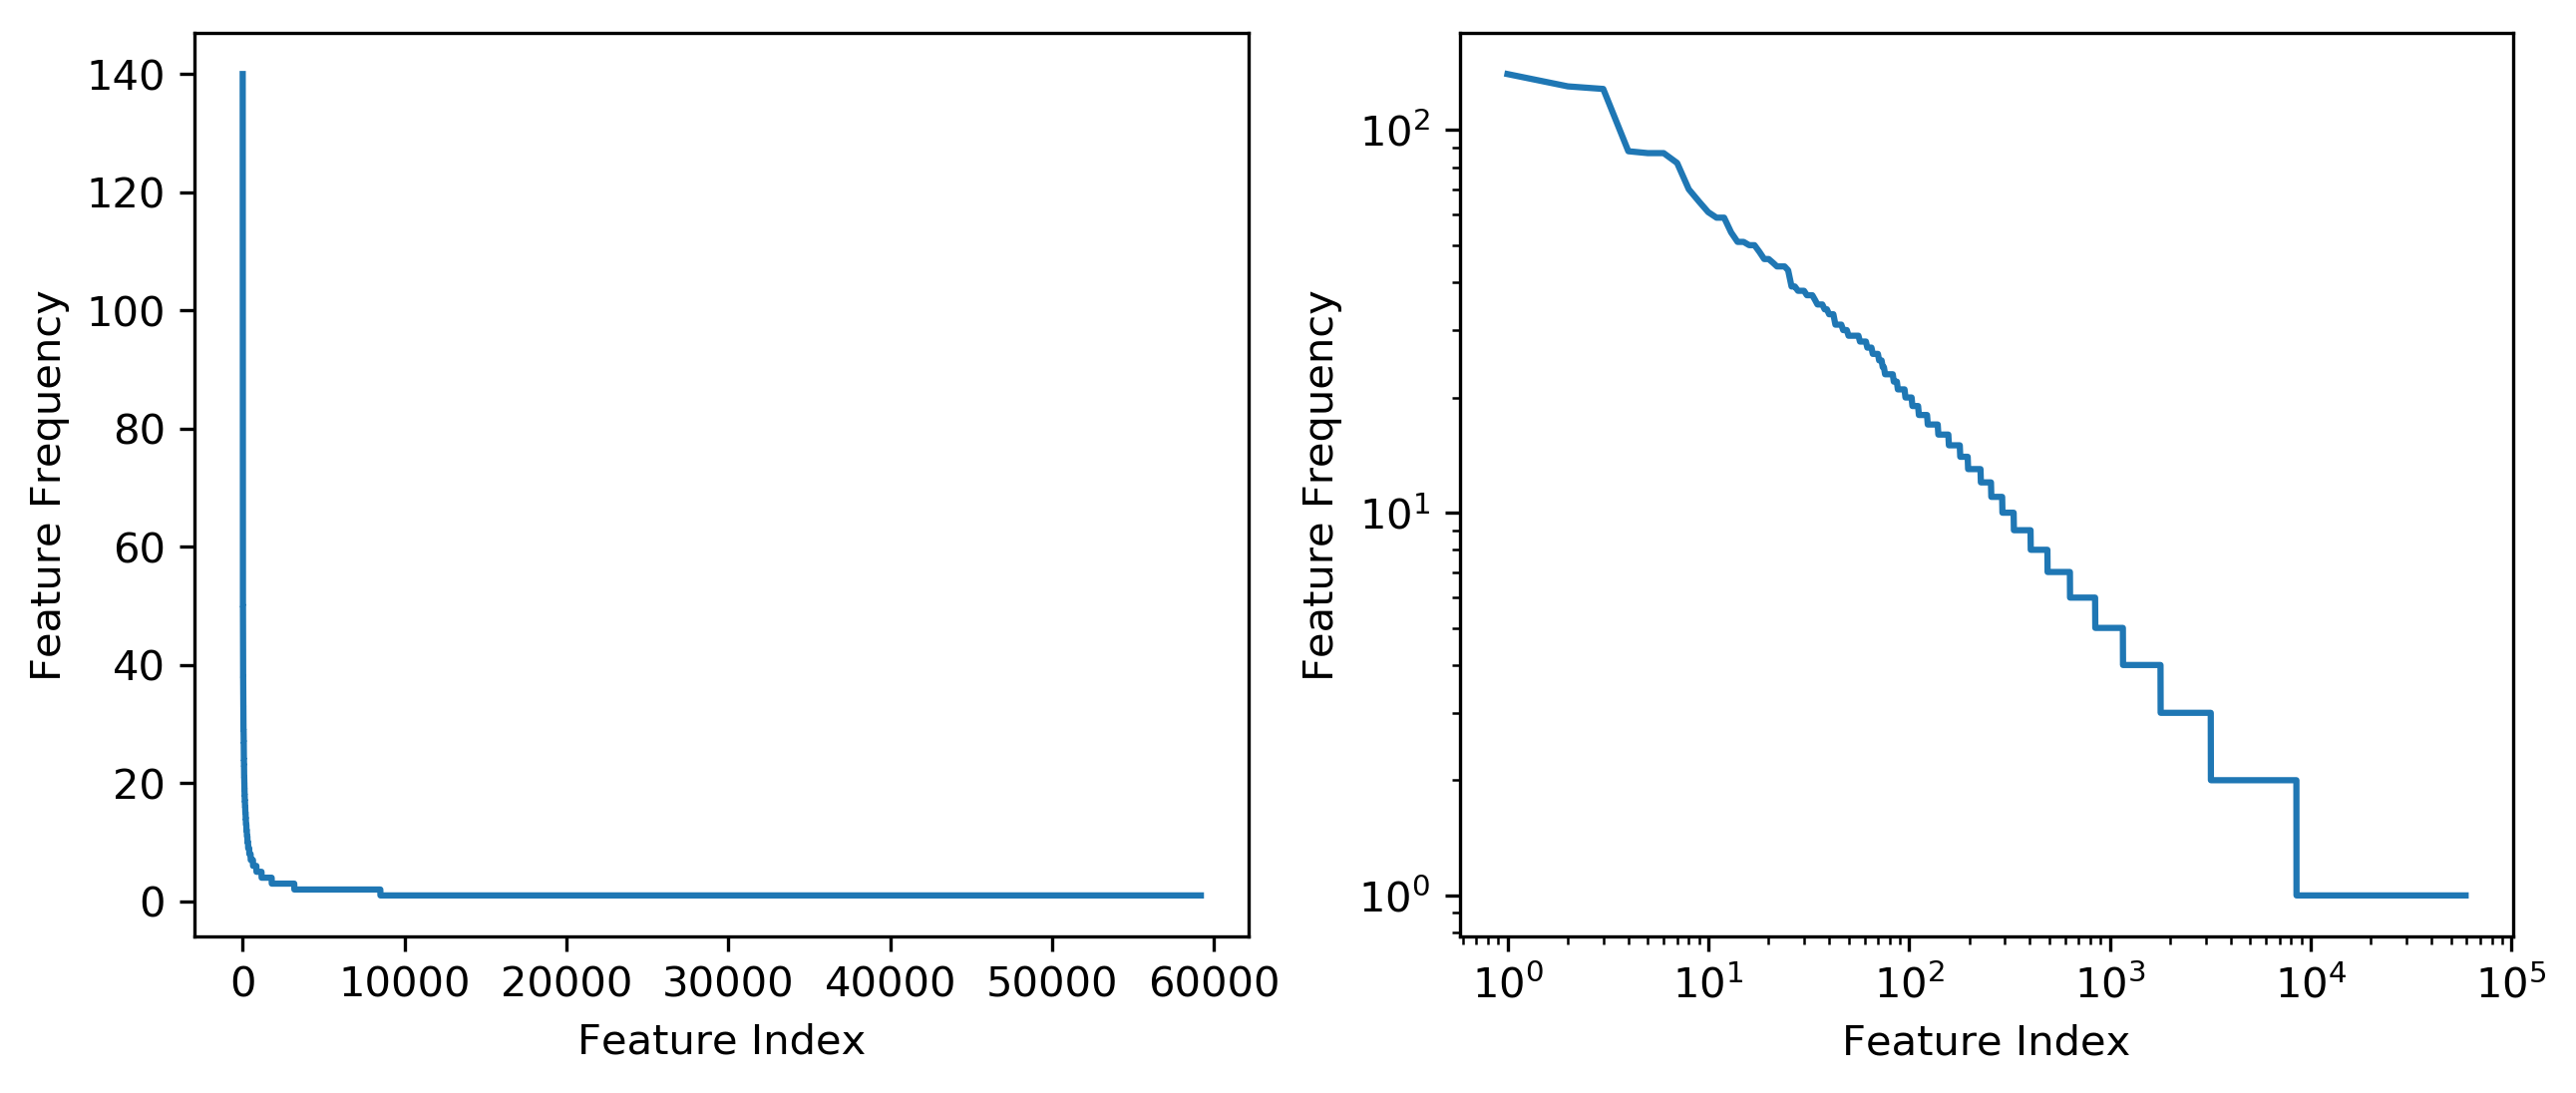

In [26]:
# first, build a Counter for 2-gram features
bi_gram_feat_cnt = Counter(chain.from_iterable(train_2_gram)) 
print("2-gram feature size:", len(bi_gram_feat_cnt))
# then, get the sorted features by the frequency
bi_gram_feat_keys = [f for f, cnt in bi_gram_feat_cnt.most_common()]
# draw linear lines and log lines for sorted features
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(list(range(1, len(bi_gram_feat_cnt)+1)),
        [bi_gram_feat_cnt[f] for f in bi_gram_feat_keys]) 
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
plt.subplot(1,2,2)
plt.loglog(list(range(1, len(bi_gram_feat_cnt)+1)),
         [bi_gram_feat_cnt[f] for f in bi_gram_feat_keys],
          basex=10, basey=10) 
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
plt.show()

3-gram feature size: 65228


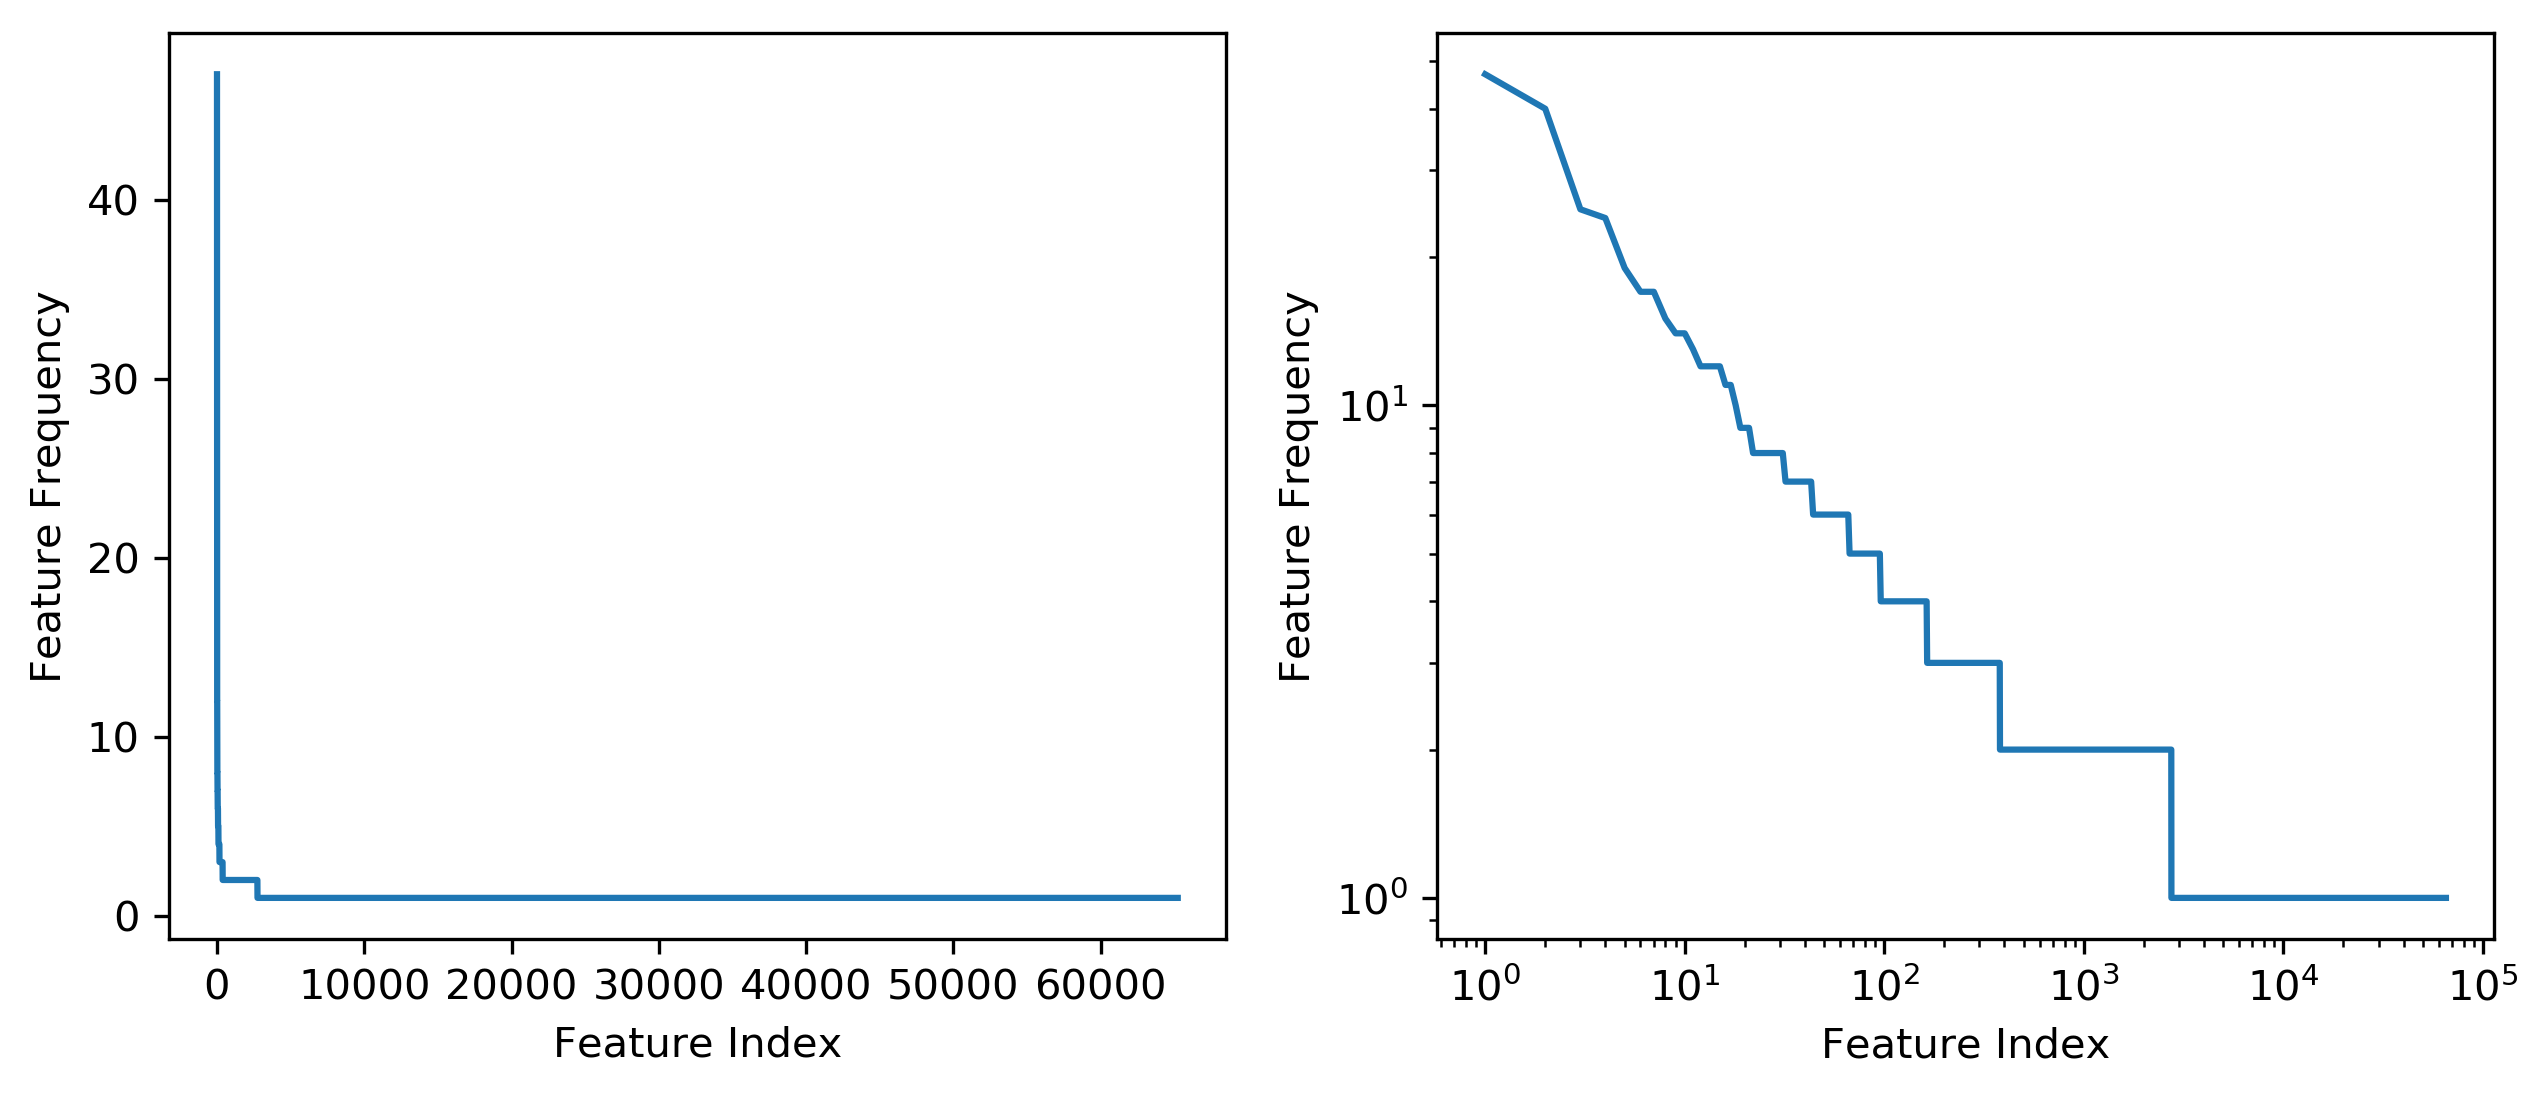

In [27]:
# first, build a Counter for 3-gram features
tri_gram_feat_cnt = Counter(chain.from_iterable(train_3_gram))
print("3-gram feature size:", len(tri_gram_feat_cnt))
# then, get the sorted features by the frequency
tri_gram_feat_keys = [f for f, cnt in tri_gram_feat_cnt.most_common()]
# draw linear lines and log lines for sorted features
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(list(range(1, len(tri_gram_feat_cnt)+1)),
        [tri_gram_feat_cnt[f] for f in tri_gram_feat_keys]) 
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
plt.subplot(1,2,2)
plt.loglog(list(range(1, len(tri_gram_feat_cnt)+1)),
           [tri_gram_feat_cnt[f] for f in tri_gram_feat_keys],
           basex=10, basey=10) 
plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency")
plt.show()

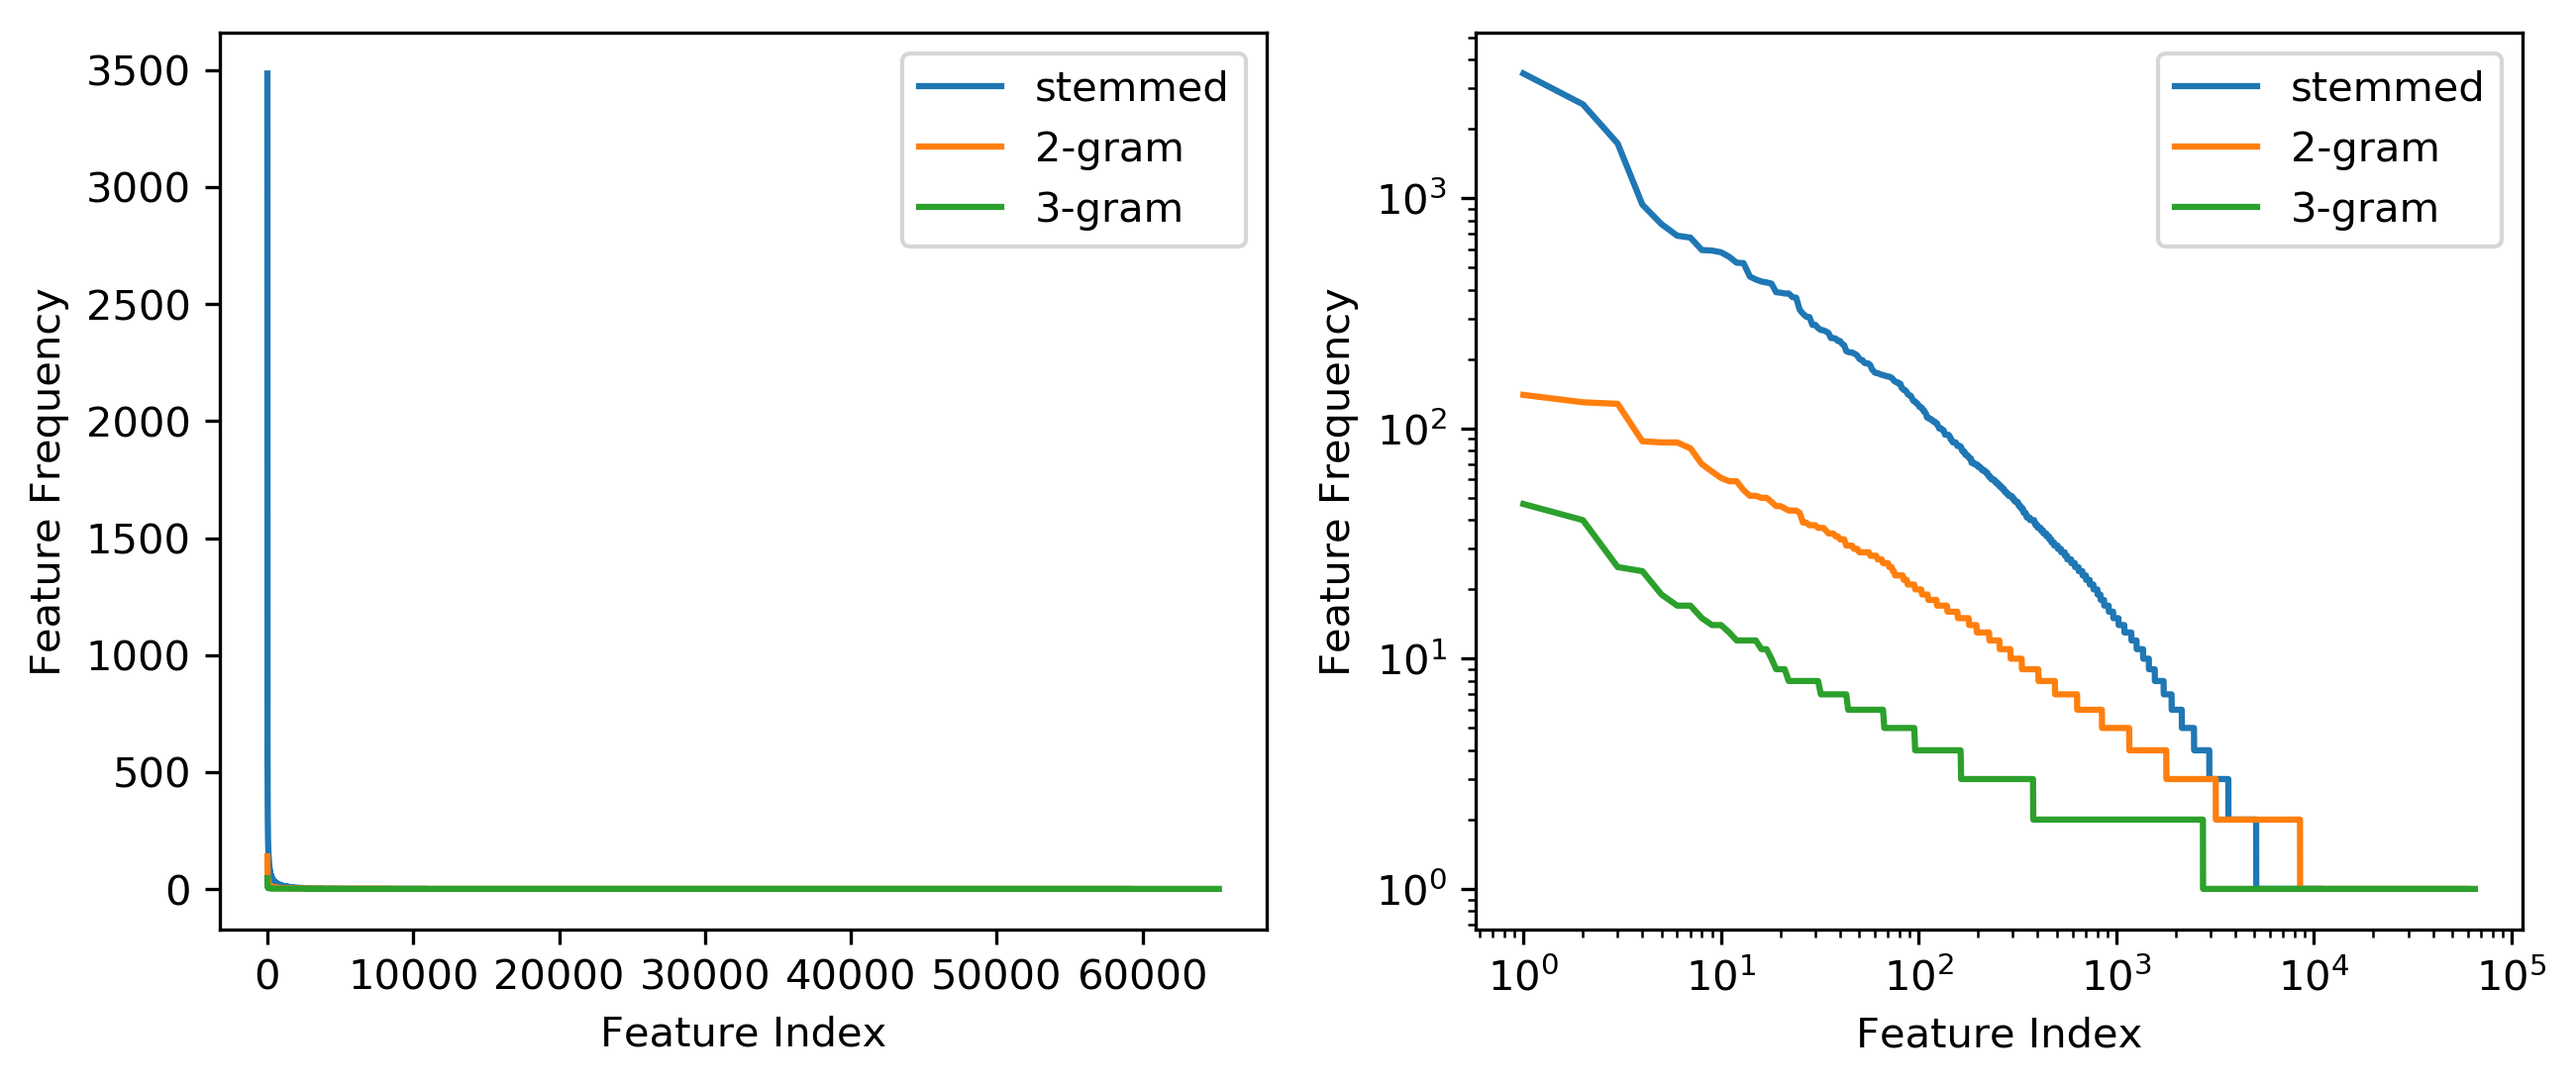

In [28]:
# draw linear lines and log lines for sorted features
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
# put the four linear lines together 
plt.plot(list(range(1, len(stemmed_feat_cnt)+1)),
[stemmed_feat_cnt[f] for f in stemmed_feat_keys],
label="stemmed")
plt.plot(list(range(1, len(bi_gram_feat_cnt)+1)),
[bi_gram_feat_cnt[f] for f in bi_gram_feat_keys],
label="2-gram")
plt.plot(list(range(1, len(tri_gram_feat_cnt)+1)),
[tri_gram_feat_cnt[f] for f in tri_gram_feat_keys],
label="3-gram")

plt.xlabel("Feature Index")
plt.ylabel("Feature Frequency") # show the legend
plt.legend()
plt.subplot(1,2,2)
# put the four log lines together
plt.loglog(list(range(1, len(stemmed_feat_cnt)+1)), [stemmed_feat_cnt[f] for f in stemmed_feat_keys], basex=10, basey=10, label="stemmed")
plt.loglog(list(range(1, len(bi_gram_feat_cnt)+1)), [bi_gram_feat_cnt[f] for f in bi_gram_feat_keys], basex=10, basey=10, label="2-gram")
plt.loglog(list(range(1, len(tri_gram_feat_cnt)+1)), [tri_gram_feat_cnt[f] for f in tri_gram_feat_keys], basex=10, basey=10, label="3-gram")
#plt.loglog(list(range(1, len(four_gram_feat_cnt)+1)), [four_gram_feat_cnt[f] for f in four_gram_feat_keys], basex=10, basey=10, label="4-gram")
plt.xlabel("Feature Index") 
plt.ylabel("Feature Frequency") # show the legend
plt.legend()
plt.show()

In [30]:
print("stemmed features > 10:",
len([f for f, cnt in stemmed_feat_cnt.items() if cnt >= 10]))
print("2-gram features > 10:",
len([f for f, cnt in bi_gram_feat_cnt.items() if cnt >= 10]))
print("3-gram features > 10:",
len([f for f, cnt in tri_gram_feat_cnt.items() if cnt >= 10]))


stemmed features > 10: 1461
2-gram features > 10: 332
3-gram features > 10: 18


In [31]:
print("stemmed features top 10:",
[(f, stemmed_feat_cnt[f]) for f in stemmed_feat_keys[:10]])
print("2-gram features top 10:",
[(f, bi_gram_feat_cnt[f]) for f in bi_gram_feat_keys[:10]])
print("3-gram features top 10:",
[(f, tri_gram_feat_cnt[f]) for f in tri_gram_feat_keys[:10]])

stemmed features top 10: [(',', 3485), ('secret', 2561), ('.', 1731), ('’', 939), ("'s", 772), ('peopl', 688), ('would', 675), ('like', 596), ('know', 593), ('gay', 583)]
2-gram features top 10: [(', would', 140), ('keep secret', 130), ('irrfan khan', 128), ("ca n't", 88), ('secret behind', 87), ("'s secret", 87), ('kept secret', 82), (', ’', 70), ('. ’', 65), ('secret ,', 61)]
3-gram features top 10: [(', etc .', 47), ('best kept secret', 40), ('actor irrfan khan', 25), ("`` secret ''", 24), ('etc . )', 19), ("irrfan khan 's", 17), ('chapter vers mean', 17), ('irrfan khan die', 15), ('gay man ,', 14), ("'s best kept", 14)]
